In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [35]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [74]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.279998,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.265805,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.258717,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.260489,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.265805,6445,ABEV3.SA


In [75]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26941 entries, 0 to 26940
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26941 non-null  datetime64[ns]
 1   Open       26941 non-null  float64       
 2   High       26941 non-null  float64       
 3   Low        26941 non-null  float64       
 4   Close      26941 non-null  float64       
 5   Adj Close  26941 non-null  float64       
 6   Volume     26941 non-null  int64         
 7   Ticker     26941 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [76]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000


In [77]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.30
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 15 dias
d = 15
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.279998,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.265805,227,ABEV3.SA,-0.026404,0.512961,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.258717,1137,ABEV3.SA,-0.013185,0.503460,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.260489,606,ABEV3.SA,0.003296,0.497799,-1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.265805,6445,ABEV3.SA,0.009889,0.496803,1.0


In [78]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 15 dias
d = 15
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.279998,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.265805,227,ABEV3.SA,-0.026404,0.512961,-1.0,0.494478,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.258717,1137,ABEV3.SA,-0.013185,0.503460,-1.0,0.481293,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.260489,606,ABEV3.SA,0.003296,0.497799,-1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.265805,6445,ABEV3.SA,0.009889,0.496803,1.0,0.494478,1.0


In [79]:
# Aplicando o deslocamento de 15 linhas dentro de cada grupo de 'Ticker'
price_data['Close_15'] = price_data.groupby('Ticker')['Close'].shift(-15)
price_data['Smoothed_Close_15'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-15)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [80]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.279998,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.487885,0.494209
5715,2024-12-03,13.250000,13.880000,13.190000,13.850000,13.126506,72892200,ABEV3.SA,0.600000,13.099786,NaN,13.850000,NaN,NaN,NaN
5716,2024-12-04,13.900000,14.060000,13.780000,13.930000,13.202327,50659000,ABEV3.SA,0.080000,13.348850,NaN,13.930000,NaN,NaN,NaN
5717,2024-12-05,14.050000,14.460000,14.000000,14.420000,13.666730,38794000,ABEV3.SA,0.490000,13.670195,NaN,14.420000,NaN,NaN,NaN
5718,2024-12-06,14.300000,14.530000,14.150000,14.220000,13.477178,46449200,ABEV3.SA,-0.200000,13.835137,NaN,14.220000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [81]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [82]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402,55.340000,60.189999,28.334384
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170,54.759998,60.189999,25.468769
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364,53.599998,60.189999,27.785560
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,27.080839
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,25.603806


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [83]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402,55.340000,60.189999,28.334384,-71.665616
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170,54.759998,60.189999,25.468769,-74.531231
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364,53.599998,60.189999,27.785560,-72.214440
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,27.080839,-72.919161
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,25.603806,-74.396194


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [84]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402,55.340000,60.189999,28.334384,-71.665616,-0.657489,-0.622574
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170,54.759998,60.189999,25.468769,-74.531231,-0.743239,-0.646707
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364,53.599998,60.189999,27.785560,-72.214440,-0.858741,-0.689114
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,27.080839,-72.919161,-0.958858,-0.743063
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,25.603806,-74.396194,-1.034453,-0.801341


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [85]:
# Período do indicador
n = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402,55.340000,60.189999,28.334384,-71.665616,-0.657489,-0.622574,-0.023319
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170,54.759998,60.189999,25.468769,-74.531231,-0.743239,-0.646707,-0.031815
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364,53.599998,60.189999,27.785560,-72.214440,-0.858741,-0.689114,-0.038231
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,27.080839,-72.919161,-0.958858,-0.743063,-0.053272
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,25.603806,-74.396194,-1.034453,-0.801341,-0.062138


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [86]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11737,2024-12-17,55.880001,56.400002,55.650002,56.110001,56.110001,22987600,VALE3.SA,0.279999,56.714217,NaN,56.110001,NaN,NaN,NaN,0.000000,0.279999,36.915402,55.340000,60.189999,28.334384,-71.665616,-0.657489,-0.622574,-0.023319,495135362
11738,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,56.142953,NaN,54.810001,NaN,NaN,NaN,1.299999,0.000000,29.625170,54.759998,60.189999,25.468769,-74.531231,-0.743239,-0.646707,-0.031815,460477162
11739,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,55.431067,NaN,53.770000,NaN,NaN,NaN,1.040001,0.000000,25.057364,53.599998,60.189999,27.785560,-72.214440,-0.858741,-0.689114,-0.038231,430947262
11740,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,55.187747,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,27.080839,-72.919161,-0.958858,-0.743063,-0.053272,366027762
11741,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,55.086422,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,25.603806,-74.396194,-1.034453,-0.801341,-0.062138,347439862


#### Salvando antes de tirar os Nans.

In [28]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D15.xlsx', index=False)

In [50]:

price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D15.parquet', index=False)

## Removendo Nans

In [87]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 26941 linhas e 26 colunas
Depois da retirada dos NaN temos 26801 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_15,Smoothed_Close_15,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.260847,75,ABEV3.SA,-0.029034,0.497965,1.0,0.485255,1.0,0.606585,0.575219,0.029034,0.000000,43.244009,0.468107,0.527474,50.294528,-49.705472,-0.001111,-0.001038,0.002340,27530
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.265805,455,ABEV3.SA,0.009223,0.496919,1.0,0.494478,1.0,0.603289,0.583640,0.000000,0.009223,47.299662,0.468107,0.527474,48.532252,-51.467748,-0.001199,-0.001071,-0.017954,27075
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.262261,5005,ABEV3.SA,-0.006593,0.494209,1.0,0.487885,1.0,0.599993,0.588546,0.006593,0.000000,44.667003,0.468107,0.527474,43.967014,-56.032986,-0.001414,-0.001142,-0.033722,22070
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.255173,3033,ABEV3.SA,-0.013185,0.488356,1.0,0.474700,1.0,0.619771,0.597913,0.013185,0.000000,39.583155,0.468107,0.527474,34.108555,-65.891445,-0.001924,-0.001302,-0.039332,19037
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.251629,11602,ABEV3.SA,-0.006593,0.482281,1.0,0.468107,1.0,0.626363,0.606448,0.006593,0.000000,37.143972,0.468107,0.527474,23.875988,-76.124012,-0.002673,-0.001581,-0.028202,7435


## VALIDAÇÃO

### Geral

In [88]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']  # Training variable (Prediction)
Verify = price_data['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.4509628302731751

Fold 2:
Accuracy for fold 2: 0.5450067174205105

Fold 3:
Accuracy for fold 3: 0.5116435288849082

Fold 4:
Accuracy for fold 4: 0.4993282579489476

Fold 5:
Accuracy for fold 5: 0.5002239140170175

                precision    recall  f1-score      support  accuracy
1 Down Day       0.429220  0.545717  0.480508  2078.000000  0.450963
  Up Day         0.482456  0.368509  0.417854  2388.000000  0.450963
  accuracy       0.450963  0.450963  0.450963     0.450963  0.450963
  macro avg      0.455838  0.457113  0.449181  4466.000000  0.450963
  weighted avg   0.457686  0.450963  0.447007  4466.000000  0.450963
2 Down Day       0.511722  0.605742  0.554777  2090.000000  0.545007
  Up Day         0.586345  0.491582  0.534799  2376.000000  0.545007
  accuracy       0.545007  0.545007  0.545007     0.545007  0.545007
  macro avg      0.549034  0.548662  0.544788  4466.000000  0.545007
  weighted avg   0.551423  0.545007  0.544148  4466.000000  0.545

In [89]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Verify']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.45521719659650695

Fold 2:
Accuracy for fold 2: 0.4872369010300045

Fold 3:
Accuracy for fold 3: 0.5181370353784147

Fold 4:
Accuracy for fold 4: 0.49440214957456335

Fold 5:
Accuracy for fold 5: 0.4961934617107031

                precision    recall  f1-score      support  accuracy
1 Down Day       0.437566  0.598653  0.505588  2078.000000  0.455217
  Up Day         0.486137  0.330402  0.393418  2388.000000  0.455217
  accuracy       0.455217  0.455217  0.455217     0.455217  0.455217
  macro avg      0.461851  0.464527  0.449503  4466.000000  0.455217
  weighted avg   0.463537  0.455217  0.445610  4466.000000  0.455217
2 Down Day       0.459283  0.539713  0.496260  2090.000000  0.487237
  Up Day         0.521393  0.441077  0.477884  2376.000000  0.487237
  accuracy       0.487237  0.487237  0.487237     0.487237  0.487237
  macro avg      0.490338  0.490395  0.487072  4466.000000  0.487237
  weighted avg   0.492327  0.487237  0.486484  4466.000000  0.4

In [90]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.47917599641737574

Fold 2:
Accuracy for fold 2: 0.5709807433945365

Fold 3:
Accuracy for fold 3: 0.5105239587998208

Fold 4:
Accuracy for fold 4: 0.541424093148231

Fold 5:
Accuracy for fold 5: 0.5535154500671742

                precision    recall  f1-score      support  accuracy
1 Down Day       0.442468  0.578140  0.501286  2022.000000  0.479176
  Up Day         0.532346  0.397300  0.455014  2444.000000  0.479176
  accuracy       0.479176  0.479176  0.479176     0.479176  0.479176
  macro avg      0.487407  0.487720  0.478150  4466.000000  0.479176
  weighted avg   0.491654  0.479176  0.475964  4466.000000  0.479176
2 Down Day       0.533549  0.634006  0.579456  2082.000000  0.570981
  Up Day         0.617470  0.515940  0.562157  2384.000000  0.570981
  accuracy       0.570981  0.570981  0.570981     0.570981  0.570981
  macro avg      0.575509  0.574973  0.570806  4466.000000  0.570981
  weighted avg   0.578347  0.570981  0.570222  4466.000000  0.570

In [91]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  69.91493806894493


In [92]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Verify']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  69.81047604835099


### AMBEV

#### Time Series Cross-Validation.

In [53]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.260847,75,ABEV3.SA,-0.029034,0.503659,1.0,0.485255,1.0,0.540659,0.505835,0.029034,0.000000,43.244009,0.468107,0.527474,59.884943,-40.115057,-0.001383,-0.001015,-0.012131,15246
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.265805,455,ABEV3.SA,0.009223,0.502741,1.0,0.494478,1.0,0.556475,0.510899,0.000000,0.009223,47.299662,0.468107,0.527474,58.338476,-41.661524,-0.001503,-0.001116,-0.017330,14791
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.262261,5005,ABEV3.SA,-0.006593,0.501255,1.0,0.487885,1.0,0.567030,0.516512,0.006593,0.000000,44.667003,0.468107,0.527474,55.836108,-44.163892,-0.001665,-0.001229,-0.022635,9786
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.255173,3033,ABEV3.SA,-0.013185,0.498600,1.0,0.474700,1.0,0.567030,0.521564,0.013185,0.000000,39.583155,0.468107,0.527474,51.363045,-48.636955,-0.001933,-0.001373,-0.025578,6753
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.251629,11602,ABEV3.SA,-0.006593,0.495550,1.0,0.468107,1.0,0.593400,0.528748,0.006593,0.000000,37.143972,0.468107,0.527474,46.226741,-53.773259,-0.002306,-0.001563,-0.023218,-4849


In [55]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.5909568874868559

Fold 2:
Accuracy for fold 2: 0.694006309148265

Fold 3:
Accuracy for fold 3: 0.6098843322818086

Fold 4:
Accuracy for fold 4: 0.6803364879074658

Fold 5:
Accuracy for fold 5: 0.7213459516298633

                precision    recall  f1-score     support  accuracy
1 Down Day       0.474265  0.344000  0.398764  375.000000  0.590957
  Up Day         0.637703  0.751736  0.690040  576.000000  0.590957
  accuracy       0.590957  0.590957  0.590957    0.590957  0.590957
  macro avg      0.555984  0.547868  0.544402  951.000000  0.590957
  weighted avg   0.573255  0.590957  0.575183  951.000000  0.590957
2 Down Day       0.402027  0.510730  0.449905  233.000000  0.694006
  Up Day         0.825954  0.753482  0.788055  718.000000  0.694006
  accuracy       0.694006  0.694006  0.694006    0.694006  0.694006
  macro avg      0.613991  0.632106  0.618980  951.000000  0.694006
  weighted avg   0.722090  0.694006  0.705207  951.000000  0.694006
3 Down D

#### Plotagem Time-Series Cross Validation

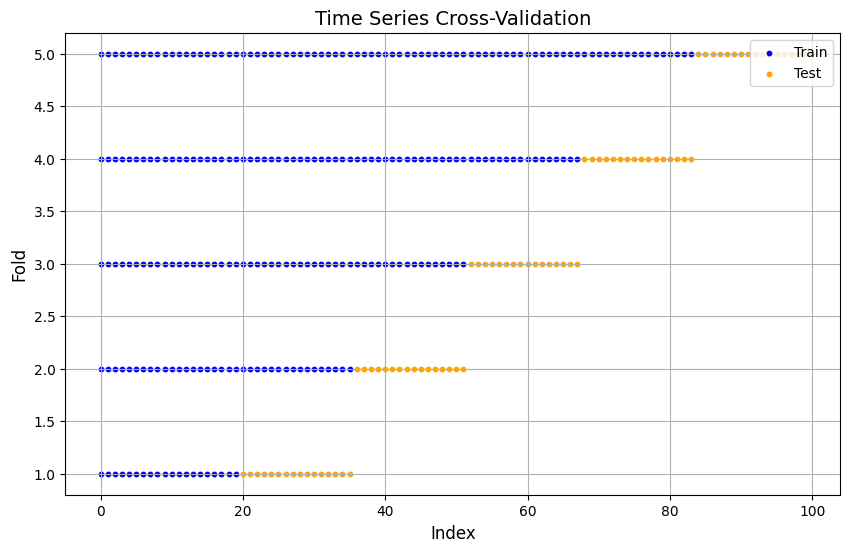

In [19]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [43]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_ABEV):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.3333
Window 2 Accuracy: 0.3333
Window 3 Accuracy: 0.7000
Window 4 Accuracy: 0.6333
Window 5 Accuracy: 0.7333
Window 6 Accuracy: 0.9000
Window 7 Accuracy: 0.4000
Window 8 Accuracy: 0.4000
Window 9 Accuracy: 0.4000
Window 10 Accuracy: 0.5333
Window 11 Accuracy: 0.3667
Window 12 Accuracy: 0.3000
Window 13 Accuracy: 0.9667
Window 14 Accuracy: 0.5333
Window 15 Accuracy: 0.5667
Window 16 Accuracy: 0.6000
Window 17 Accuracy: 0.8667
Window 18 Accuracy: 0.8000
Window 19 Accuracy: 0.7333
Window 20 Accuracy: 0.5667
Window 21 Accuracy: 0.6333
Window 22 Accuracy: 0.5333
Window 23 Accuracy: 0.5667
Window 24 Accuracy: 0.7667
Window 25 Accuracy: 1.0000
Window 26 Accuracy: 1.0000
Window 27 Accuracy: 0.5333
Window 28 Accuracy: 0.4000
Window 29 Accuracy: 0.7000
Window 30 Accuracy: 0.7667
Window 31 Accuracy: 0.6333
Window 32 Accuracy: 0.1333
Window 33 Accuracy: 1.0000
Window 34 Accuracy: 0.9000
Window 35 Accuracy: 0.4667
Window 36 Accuracy: 0.8667
Window 37 Accuracy: 1.0000
Window 38 

#### Outras métricas de acurácia.

In [21]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.822055,0.580531,0.680498,565.000000
Up Day,0.630841,0.850840,0.724508,476.000000
accuracy,0.704131,0.704131,0.704131,0.704131
macro avg,0.726448,0.715686,0.702503,1041.000000
weighted avg,0.734622,0.704131,0.700622,1041.000000


Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


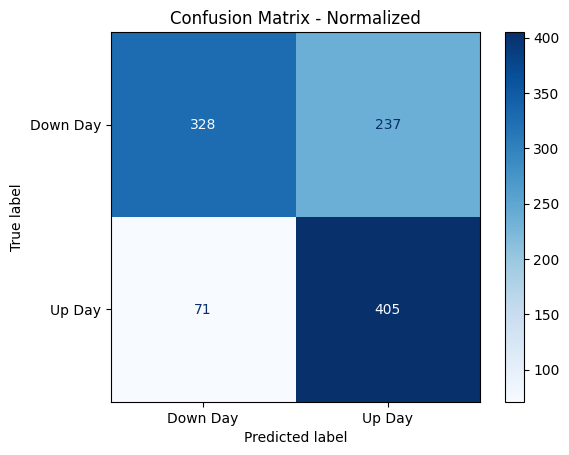

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [1]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para AMBEV.

In [51]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Split normal sem cross-validation.

In [27]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  83.42930262316058


In [28]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.797364,0.780645,0.788916,620.000000
Up Day,0.857741,0.869565,0.863612,943.000000
accuracy,0.834293,0.834293,0.834293,0.834293
macro avg,0.827552,0.825105,0.826264,1563.000000
weighted avg,0.833791,0.834293,0.833982,1563.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [54]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']  # Training variable (Prediction)
Verify = price_data_ABEV['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.4931650893796004

Fold 2:
Accuracy for fold 2: 0.501577287066246

Fold 3:
Accuracy for fold 3: 0.4426919032597266

Fold 4:
Accuracy for fold 4: 0.5541535226077813

Fold 5:
Accuracy for fold 5: 0.5068349106203995

                precision    recall  f1-score     support  accuracy
1 Down Day       0.371324  0.245146  0.295322  412.000000  0.493165
  Up Day         0.541973  0.682746  0.604269  539.000000  0.493165
  accuracy       0.493165  0.493165  0.493165    0.493165  0.493165
  macro avg      0.456649  0.463946  0.449795  951.000000  0.493165
  weighted avg   0.468043  0.493165  0.470424  951.000000  0.493165
2 Down Day       0.273649  0.238235  0.254717  340.000000  0.501577
  Up Day         0.604580  0.648118  0.625592  611.000000  0.501577
  accuracy       0.501577  0.501577  0.501577    0.501577  0.501577
  macro avg      0.439114  0.443177  0.440155  951.000000  0.501577
  weighted avg   0.486266  0.501577  0.492998  951.000000  0.501577
3 Down D

### ITAÚ

#### Time series Cross-Validation

In [24]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17815,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.775112,49788916,ITUB4.SA,-0.049343,3.039109,1.0,3.080100,1.0,3.129443,3.128212,0.049343,0.000000,54.433299,2.790006,3.228790,56.771310,-43.228690,0.011519,0.011416,0.030898,653169644
17816,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.794007,7959945,ITUB4.SA,0.032785,3.046487,1.0,3.112885,-1.0,3.079769,3.123367,0.000000,0.032785,59.382961,2.790006,3.228790,58.452674,-41.547326,0.012869,0.011706,0.032845,661129589
17817,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.803549,26138577,ITUB4.SA,0.016558,3.054783,1.0,3.129443,-1.0,3.088048,3.119835,0.000000,0.016558,61.800980,2.790006,3.228790,60.343261,-39.656739,0.014234,0.012212,0.031102,687268166
17818,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.817864,52977726,ITUB4.SA,0.024837,3.064732,1.0,3.154280,-1.0,3.030096,3.110862,0.000000,0.024837,65.369227,2.831401,3.228790,58.716078,-41.283922,0.015714,0.012912,0.028669,740245892
17819,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.879889,141660459,ITUB4.SA,0.107626,3.084450,1.0,3.261906,-1.0,3.046653,3.104441,0.000000,0.107626,76.394363,2.864351,3.261906,55.363083,-44.636917,0.017898,0.013910,0.029533,881906351


In [25]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.594622543950362

Fold 2:
Accuracy for fold 2: 0.5429162357807652

Fold 3:
Accuracy for fold 3: 0.6618407445708376

Fold 4:
Accuracy for fold 4: 0.6204756980351603

Fold 5:
Accuracy for fold 5: 0.6680455015511892

                precision    recall  f1-score     support  accuracy
1 Down Day       0.463504  0.341398  0.393189  372.000000  0.594623
  Up Day         0.646465  0.752941  0.695652  595.000000  0.594623
  accuracy       0.594623  0.594623  0.594623    0.594623  0.594623
  macro avg      0.554984  0.547170  0.544421  967.000000  0.594623
  weighted avg   0.576080  0.594623  0.579296  967.000000  0.594623
2 Down Day       0.478788  0.763285  0.588454  414.000000  0.542916
  Up Day         0.680782  0.377939  0.486047  553.000000  0.542916
  accuracy       0.542916  0.542916  0.542916    0.542916  0.542916
  macro avg      0.579785  0.570612  0.537250  967.000000  0.542916
  weighted avg   0.594302  0.542916  0.529890  967.000000  0.542916
3 Down D

#### Plotagem Time-Series Cross Validation

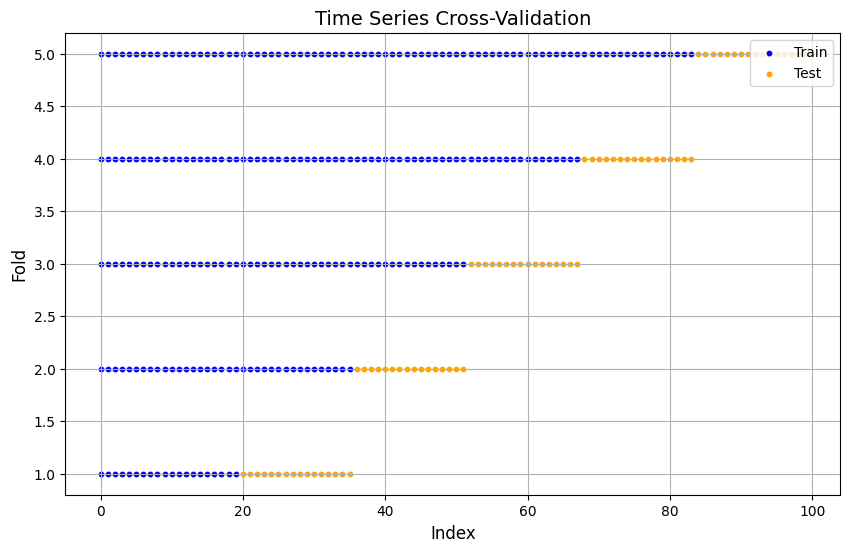

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Itau):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.822055,0.580531,0.680498,565.000000
Up Day,0.630841,0.850840,0.724508,476.000000
accuracy,0.704131,0.704131,0.704131,0.704131
macro avg,0.726448,0.715686,0.702503,1041.000000
weighted avg,0.734622,0.704131,0.700622,1041.000000


Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


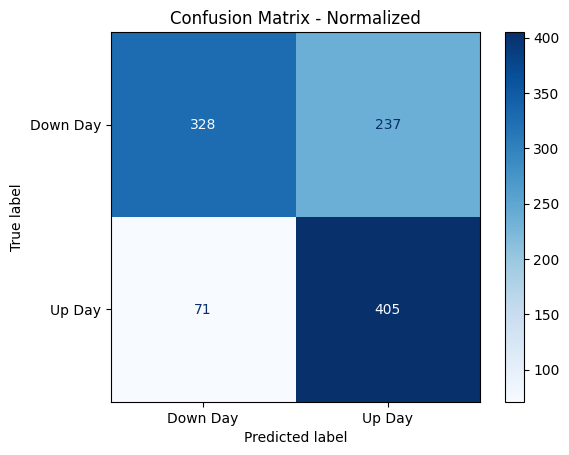

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para ITAU.

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Split normal sem cross-validation.

In [ ]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  83.42930262316058


In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.797364,0.780645,0.788916,620.000000
Up Day,0.857741,0.869565,0.863612,943.000000
accuracy,0.834293,0.834293,0.834293,0.834293
macro avg,0.827552,0.825105,0.826264,1563.000000
weighted avg,0.833791,0.834293,0.833982,1563.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']  # Training variable (Prediction)
Verify = price_data_Itau['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.4931650893796004

Fold 2:
Accuracy for fold 2: 0.501577287066246

Fold 3:
Accuracy for fold 3: 0.4426919032597266

Fold 4:
Accuracy for fold 4: 0.5541535226077813

Fold 5:
Accuracy for fold 5: 0.5068349106203995

                precision    recall  f1-score     support  accuracy
1 Down Day       0.371324  0.245146  0.295322  412.000000  0.493165
  Up Day         0.541973  0.682746  0.604269  539.000000  0.493165
  accuracy       0.493165  0.493165  0.493165    0.493165  0.493165
  macro avg      0.456649  0.463946  0.449795  951.000000  0.493165
  weighted avg   0.468043  0.493165  0.470424  951.000000  0.493165
2 Down Day       0.273649  0.238235  0.254717  340.000000  0.501577
  Up Day         0.604580  0.648118  0.625592  611.000000  0.501577
  accuracy       0.501577  0.501577  0.501577    0.501577  0.501577
  macro avg      0.439114  0.443177  0.440155  951.000000  0.501577
  weighted avg   0.486266  0.501577  0.492998  951.000000  0.501577
3 Down D

### MAGALU

#### Time series Cross-Validation

In [27]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
23641,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274923,935719,MGLU3.SA,-0.017537,4.731706,-1.0,4.641542,1.0,4.881218,4.726884,0.017537,0.000000,32.626397,4.533395,4.878295,57.498153,-42.501847,-0.008123,-0.028372,-0.013872,-13212506
23642,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218390,3585840,MGLU3.SA,-0.061381,4.716552,1.0,4.580161,1.0,4.878295,4.742025,0.061381,0.000000,25.316822,4.533395,4.878295,53.104275,-46.895725,-0.010219,-0.024741,-0.015133,-16798346
23643,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091865,1985366,MGLU3.SA,-0.137376,4.689175,1.0,4.442785,1.0,4.846144,4.752437,0.137376,0.000000,16.037903,4.439862,4.822760,65.112083,-34.887917,-0.013341,-0.022461,-0.020942,-18783712
23644,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234543,1263135,MGLU3.SA,0.154913,4.680027,1.0,4.597698,1.0,4.998134,4.777007,0.000000,0.154913,43.149183,4.436940,4.822760,63.005301,-36.994699,-0.016122,-0.021193,-0.023054,-20046847
23645,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.673840,1.0,4.618158,1.0,5.012748,4.800581,0.000000,0.020460,45.815425,4.436940,4.822760,61.401720,-38.598280,-0.018445,-0.020644,-0.024110,-21824884


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Maglu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Maglu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Maglu.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


#### Plotagem Time-Series Cross Validation

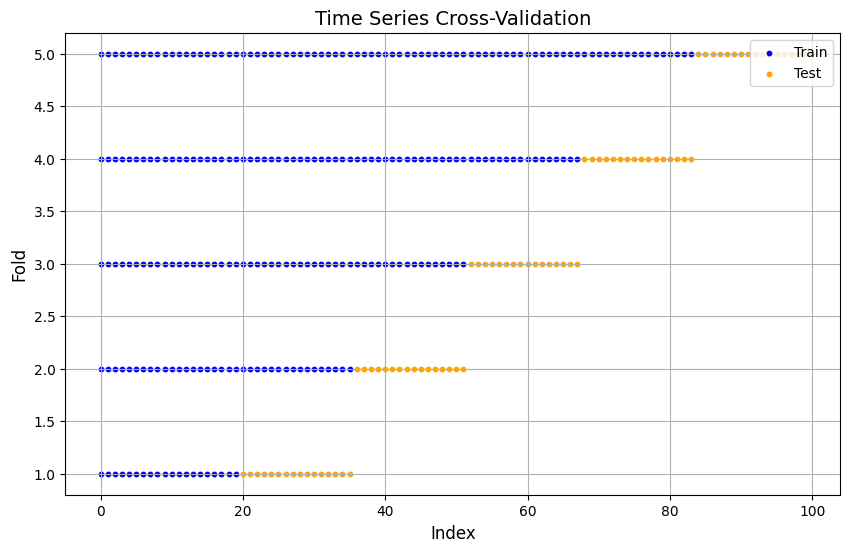

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Magalu):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Maglu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Maglu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Maglu.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.3333
Window 2 Accuracy: 0.3333
Window 3 Accuracy: 0.7000
Window 4 Accuracy: 0.6333
Window 5 Accuracy: 0.7333
Window 6 Accuracy: 0.9000
Window 7 Accuracy: 0.4000
Window 8 Accuracy: 0.4000
Window 9 Accuracy: 0.4000
Window 10 Accuracy: 0.5333
Window 11 Accuracy: 0.3667
Window 12 Accuracy: 0.3000
Window 13 Accuracy: 0.9667
Window 14 Accuracy: 0.5333
Window 15 Accuracy: 0.5667
Window 16 Accuracy: 0.6000
Window 17 Accuracy: 0.8667
Window 18 Accuracy: 0.8000
Window 19 Accuracy: 0.7333
Window 20 Accuracy: 0.5667
Window 21 Accuracy: 0.6333
Window 22 Accuracy: 0.5333
Window 23 Accuracy: 0.5667
Window 24 Accuracy: 0.7667
Window 25 Accuracy: 1.0000
Window 26 Accuracy: 1.0000
Window 27 Accuracy: 0.5333
Window 28 Accuracy: 0.4000
Window 29 Accuracy: 0.7000
Window 30 Accuracy: 0.7667
Window 31 Accuracy: 0.6333
Window 32 Accuracy: 0.1333
Window 33 Accuracy: 1.0000
Window 34 Accuracy: 0.9000
Window 35 Accuracy: 0.4667
Window 36 Accuracy: 0.8667
Window 37 Accuracy: 1.0000
Window 38 

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


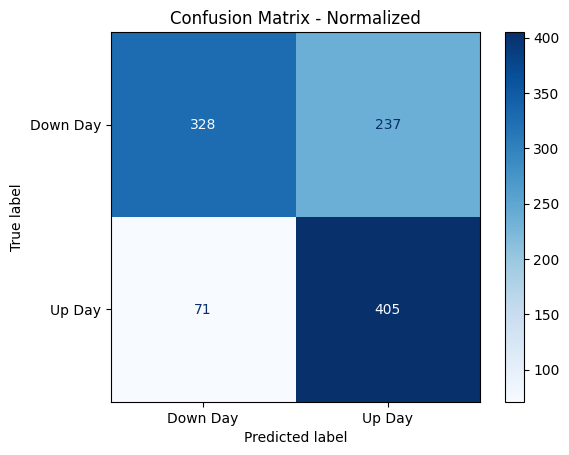

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Maglu, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para MAGALU.

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Maglu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Split normal sem cross-validation.

In [ ]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Maglu = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Maglu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Maglu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Maglu.predict(X_test), normalize = True) * 100.0)

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']  # Training variable (Prediction)
Verify = price_data_Magalu['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf_Maglu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf_Maglu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Maglu.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


### Petrobrás.

#### Time series Cross-Validation

In [17]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11755,2000-01-20,5.313,5.313,5.313,5.313,1.159219,26268160000,PETR4.SA,-0.012,5.524186,-1.0,5.313,1.0,5.588,5.374198,0.012,0.000,27.170336,5.313,5.875,37.577523,-62.422477,-0.033294,-0.032542,-0.038762,-336407040000
11756,2000-01-21,5.200,5.200,5.200,5.200,1.134564,17512960000,PETR4.SA,-0.113,5.491767,-1.0,5.200,1.0,5.625,5.399278,0.113,0.000,20.428414,5.200,5.613,70.645841,-29.354159,-0.037668,-0.033567,-0.042170,-353920000000
11757,2000-01-24,5.163,5.163,5.163,5.163,1.126491,18385920000,PETR4.SA,-0.037,5.458890,-1.0,5.163,1.0,5.750,5.434350,0.037,0.000,18.677468,5.163,5.613,65.753448,-34.246552,-0.042507,-0.035355,-0.043591,-372305920000
11758,2000-01-26,5.225,5.225,5.225,5.225,1.140018,25917440000,PETR4.SA,0.062,5.435501,1.0,5.225,1.0,5.463,5.437215,0.000,0.062,30.238440,5.163,5.613,60.555877,-39.444123,-0.047117,-0.037707,-0.043925,-398223360000
11759,2000-01-27,5.188,5.188,5.188,5.188,1.131946,38379520000,PETR4.SA,-0.037,5.410751,1.0,5.188,1.0,5.288,5.422294,0.037,0.000,27.542316,5.163,5.613,55.055847,-44.944153,-0.051630,-0.040492,-0.042210,-436602880000


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


#### Plotagem Time-Series Cross Validation

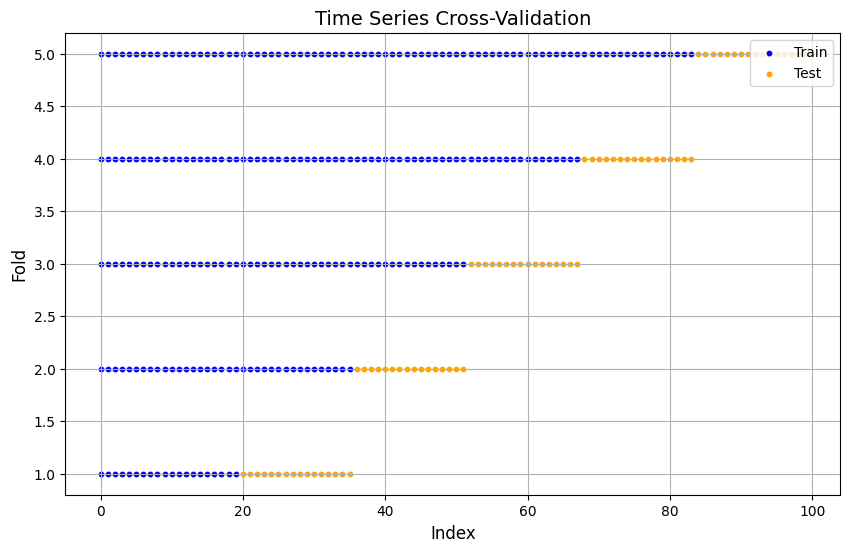

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Petro):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.3333
Window 2 Accuracy: 0.3333
Window 3 Accuracy: 0.7000
Window 4 Accuracy: 0.6333
Window 5 Accuracy: 0.7333
Window 6 Accuracy: 0.9000
Window 7 Accuracy: 0.4000
Window 8 Accuracy: 0.4000
Window 9 Accuracy: 0.4000
Window 10 Accuracy: 0.5333
Window 11 Accuracy: 0.3667
Window 12 Accuracy: 0.3000
Window 13 Accuracy: 0.9667
Window 14 Accuracy: 0.5333
Window 15 Accuracy: 0.5667
Window 16 Accuracy: 0.6000
Window 17 Accuracy: 0.8667
Window 18 Accuracy: 0.8000
Window 19 Accuracy: 0.7333
Window 20 Accuracy: 0.5667
Window 21 Accuracy: 0.6333
Window 22 Accuracy: 0.5333
Window 23 Accuracy: 0.5667
Window 24 Accuracy: 0.7667
Window 25 Accuracy: 1.0000
Window 26 Accuracy: 1.0000
Window 27 Accuracy: 0.5333
Window 28 Accuracy: 0.4000
Window 29 Accuracy: 0.7000
Window 30 Accuracy: 0.7667
Window 31 Accuracy: 0.6333
Window 32 Accuracy: 0.1333
Window 33 Accuracy: 1.0000
Window 34 Accuracy: 0.9000
Window 35 Accuracy: 0.4667
Window 36 Accuracy: 0.8667
Window 37 Accuracy: 1.0000
Window 38 

#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

#### Split normal sem cross-validation.

In [ ]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']  # Training variable (Prediction)
Verify = price_data_Petro['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


### Vale.

#### Time series Cross-Validation

In [18]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5743,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.634191,144000,VALE3.SA,-0.083334,3.816120,1.0,3.916666,1.0,4.000000,3.950014,0.083334,0.000000,55.357618,3.375000,4.166666,55.720498,-44.279502,0.039181,0.042312,0.082815,21388800
5744,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.655053,196800,VALE3.SA,0.050000,3.831175,1.0,3.966666,-1.0,3.790833,3.934096,0.000000,0.050000,60.156173,3.375000,4.166666,57.622130,-42.377870,0.042333,0.042316,0.077384,21585600
5745,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.668961,211200,VALE3.SA,0.033334,3.848057,1.0,4.000000,-1.0,3.741666,3.914853,0.000000,0.033334,63.199074,3.375000,4.166666,59.754660,-40.245340,0.045218,0.042896,0.072385,21796800
5746,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.634191,148800,VALE3.SA,-0.083334,3.854918,1.0,3.916666,-1.0,3.833333,3.906701,0.083334,0.000000,51.789901,3.458333,4.166666,55.988524,-44.011476,0.047280,0.043773,0.061868,21945600
5747,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.564651,739200,VALE3.SA,-0.166666,3.844426,1.0,3.750000,1.0,3.833333,3.899364,0.166666,0.000000,36.559368,3.750000,4.166666,22.662369,-77.337631,0.047618,0.044542,0.045926,21206400


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


#### Plotagem Time-Series Cross Validation

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Vale):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

#### Split normal sem cross-validation.

In [ ]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']  # Training variable (Prediction)
Verify = price_data_Vale['Verify']  # New validation variable

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model using 'Prediction' as the target variable
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Now use 'Verify' as the validation target variable (instead of 'y_test')
    y_verify = Verify.iloc[test_index]
    
    # Generate the classification report based on 'Verify'
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_verify, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_verify, y_pred)  # Compare predictions with 'Verify'
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


### Old.

In [21]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

In [22]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.19632949210414


In [23]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.787940,0.752264,0.769689,3092.000000
Up Day,0.812117,0.840996,0.826304,3937.000000
accuracy,0.801963,0.801963,0.801963,0.801963
macro avg,0.800029,0.796630,0.797996,7029.000000
weighted avg,0.801482,0.801963,0.801399,7029.000000


Accuracy: 0.8019632949210413
Precision: 0.8121167525141035
Recall: 0.840995681991364
Specificity: 0.7522639068564037


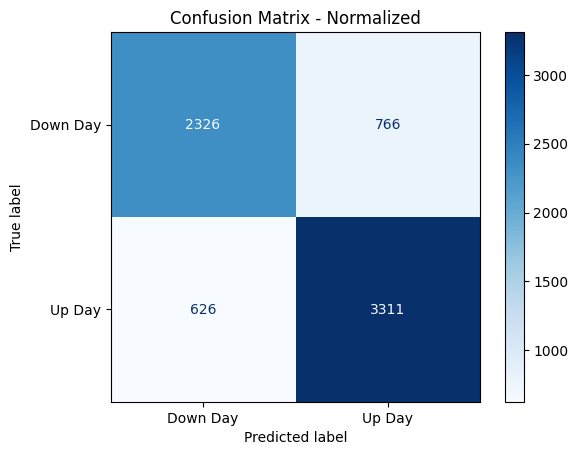

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


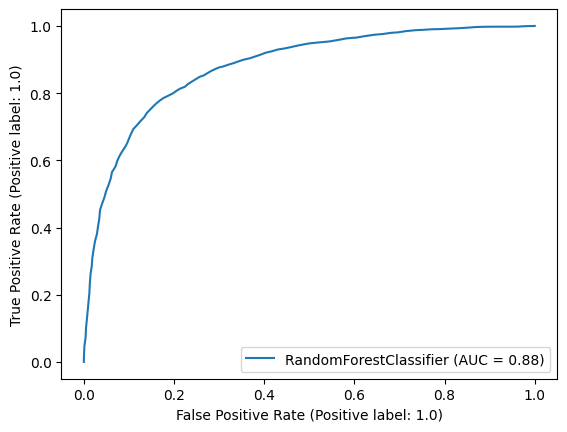

In [25]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test)
plt.show()


### Plotagem da suavição e indicador de direção da Vale. Dados reais, sem machine learning.

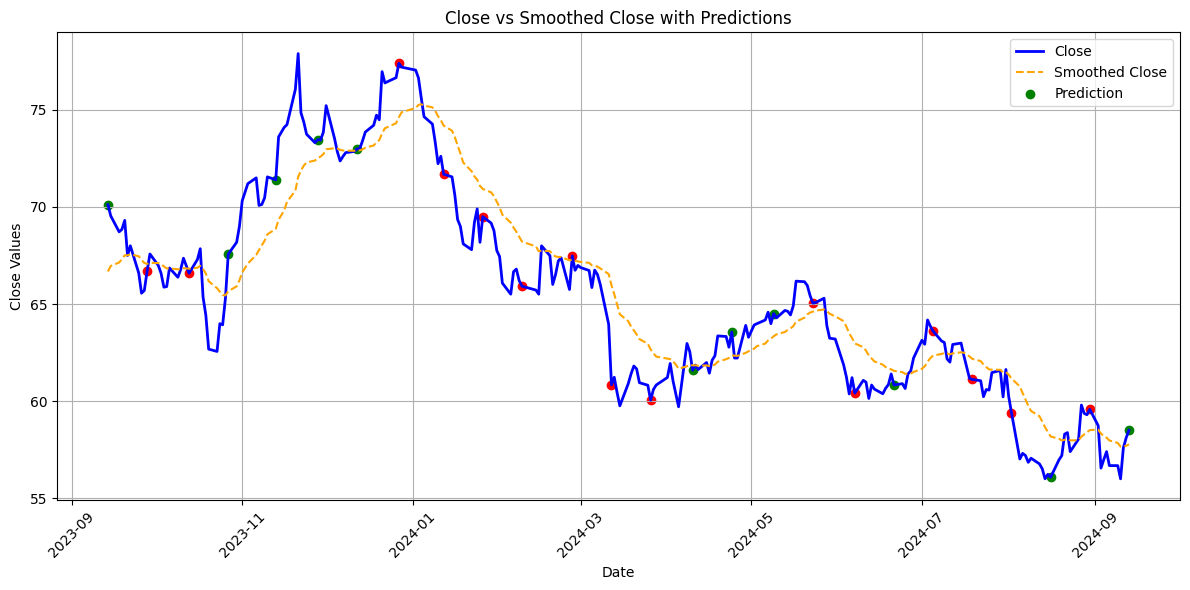

In [195]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Ambev. Dados reais, sem machine learning.

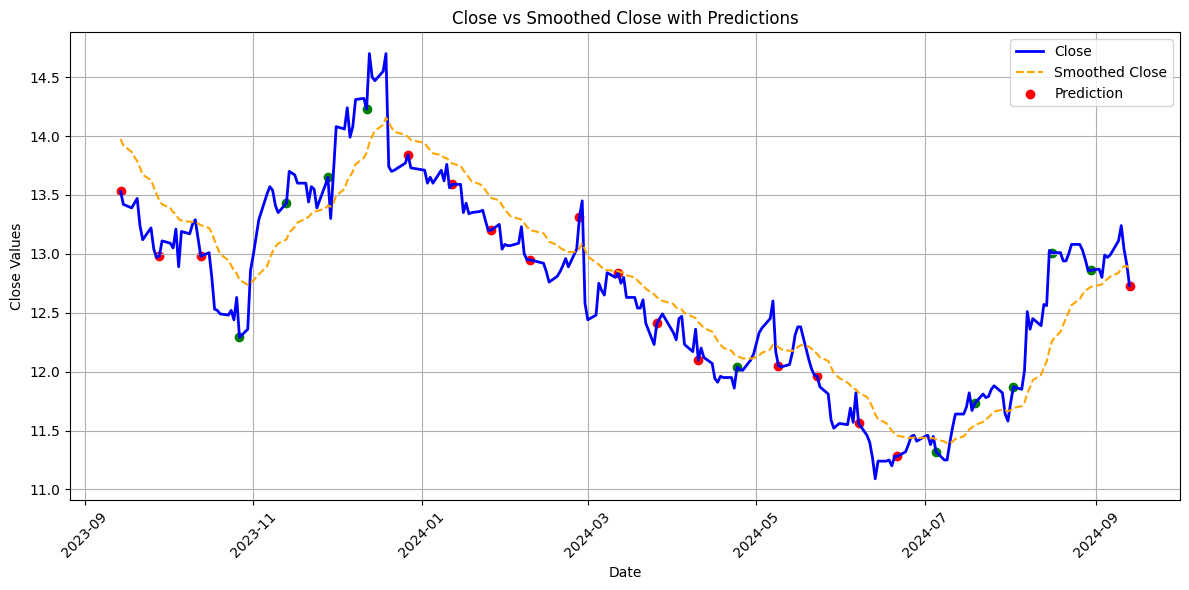

In [197]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Sabesp. Dados reais, sem machine learning.

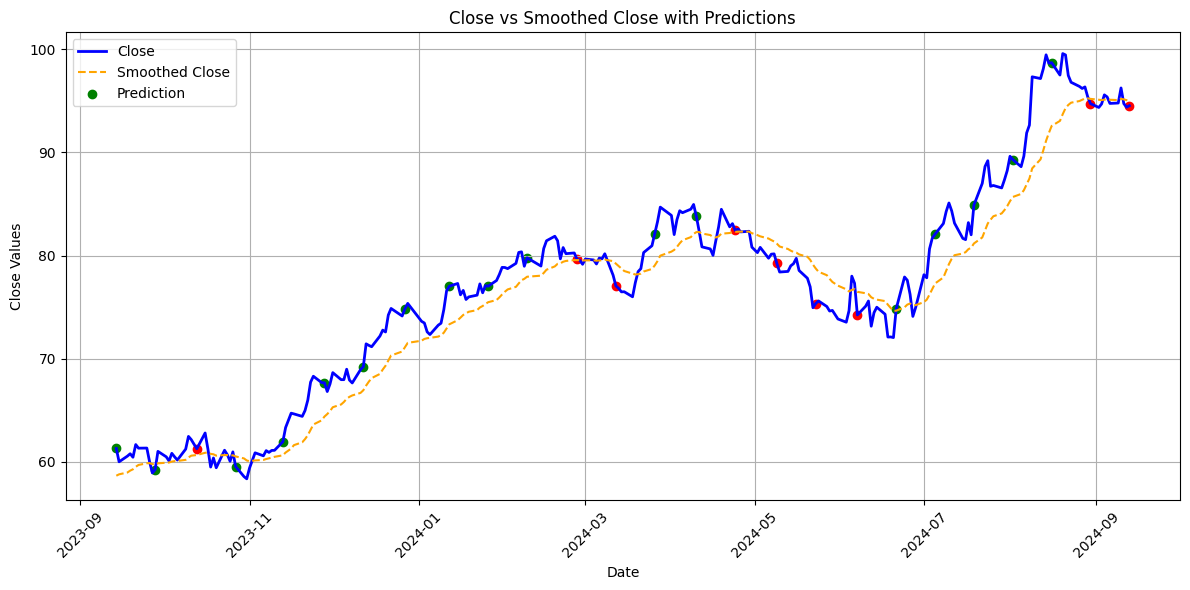

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'SBSP3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem do gráfico de Vale com predição do modelo de machine learning.

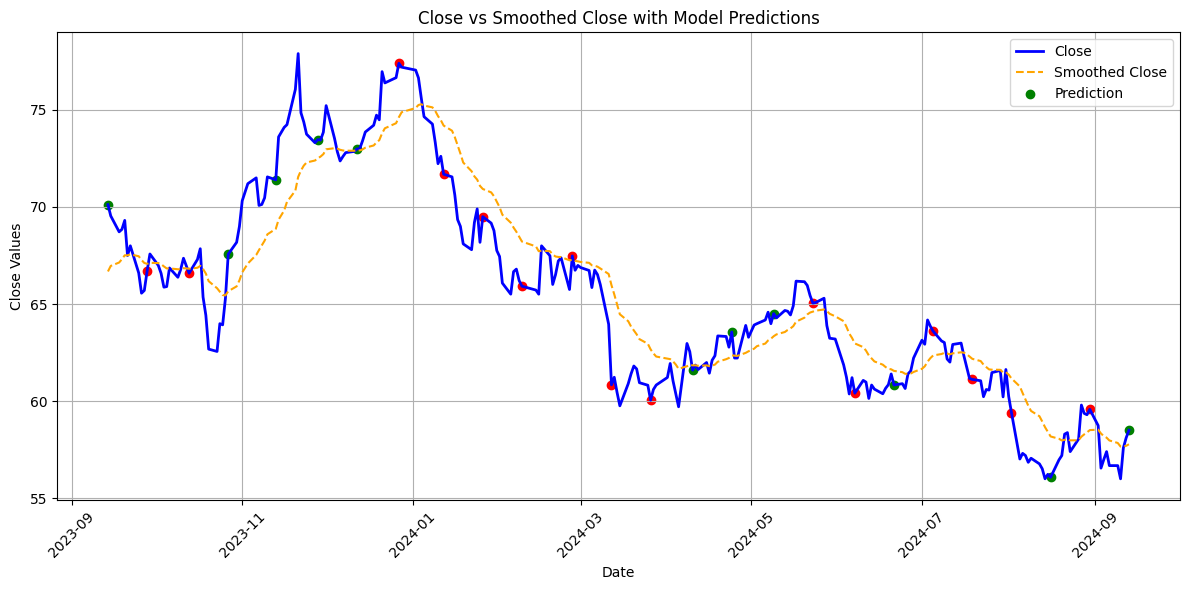

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


In [16]:
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.279998,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.505155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.265805,227,ABEV3.SA,-0.026404,0.518242,-1.0,0.494478,1.0,0.501104,0.504750,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000059,-0.000033,NaN,-227
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.258717,1137,ABEV3.SA,-0.013185,0.514547,-1.0,0.481293,1.0,0.514289,0.505704,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000190,-0.000097,NaN,-1364
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.260489,606,ABEV3.SA,0.003296,0.511551,-1.0,0.484589,1.0,0.485255,0.503659,0.000000,0.003296,9.538366,NaN,NaN,NaN,NaN,-0.000353,-0.000184,NaN,-1970
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.265805,6445,ABEV3.SA,0.009889,0.509844,-1.0,0.494478,-1.0,0.494478,0.502741,0.000000,0.009889,31.994220,NaN,NaN,NaN,NaN,-0.000502,-0.000279,NaN,-8415
